In [28]:
%%capture
!pip install -q kagglehub torch torchvision scikit-learn pandas opencv-python tqdm scikit-multilearn matplotlib seaborn PILLOW

In [29]:

import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split
from PIL import Image


## Download Dataset 
we are using the training set for EDA and modeling.

We are not using the test set for this project given it is not labeled and we want to focus on the training data for EDA and modeling


In [30]:
# 1. Download Dataset (Official ODIR-5K)
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")
print("Dataset path:", path)
IMG_DIR = os.path.join(path, "ODIR-5K/ODIR-5K/Training Images") 
print("Image directory:", IMG_DIR)
CSV_PATH = os.path.join(path, "full_df.csv")
df = pd.read_csv(CSV_PATH)
df.head()

Dataset path: /home/ray/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2
Image directory: /home/ray/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/ODIR-5K/ODIR-5K/Training Images


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


## Explore Data Set

This section includes codes from https://www.kaggle.com/code/fridahnjunge/densenet121final

In [31]:
print(f" This dataset has {df.shape[0]} observations and {df.shape[1]} variables")

 This dataset has 6392 observations and 19 variables


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [33]:
null_values_count=df.isna().sum()
duplicates_count=df.duplicated().sum()
print("Null values count:")
print(null_values_count)
print("Duplicates count:", duplicates_count)
print("Duplicated ID count:", df['ID'].duplicated().sum())

Null values count:
ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64
Duplicates count: 0
Duplicated ID count: 3034


We realise that our data contains more than 1 rows for each patient ID

In [34]:
df[df.duplicated(subset=['ID'], keep=False)].sort_values(by='ID').head(6)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg
3195,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_left.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
3197,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",4_left.jpg


For Dual Eyes approach or Binocular,  we can remove few columns:
- Patient Age
- Patient Sex
- Left-Diagnostic
- Right-Diagnostic
- filepath
- Labels
- Target
- Filename

In [35]:
df2 = df.drop(['filename', 'target', 'labels','filepath'], axis=1, inplace=False)
df2.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0


In [36]:
df2.duplicated().sum()

np.int64(3034)

In [37]:
df2.drop_duplicates(inplace=True)
df2.duplicated().sum()

np.int64(0)

multiple
1    2802
2     529
3      27
Name: count, dtype: int64


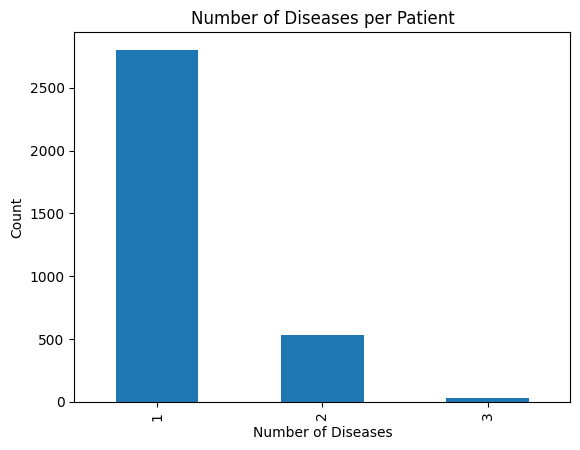

In [38]:
df2['multiple']=df2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum(axis=1)
counts= df2['multiple'].value_counts()
print(counts)
counts.plot(kind='bar')
plt.title('Number of Diseases per Patient')
plt.xlabel('Number of Diseases')
plt.ylabel('Count')
plt.show()

We can see that 529  has 2 labels, 27 has 3 labels and 2802 patient has unique 1 label


--- Univariate: Patient Age ---
count    3358.000000
mean       57.889815
std        11.730862
min         1.000000
25%        51.000000
50%        59.000000
75%        66.000000
max        91.000000
Name: Patient Age, dtype: float64


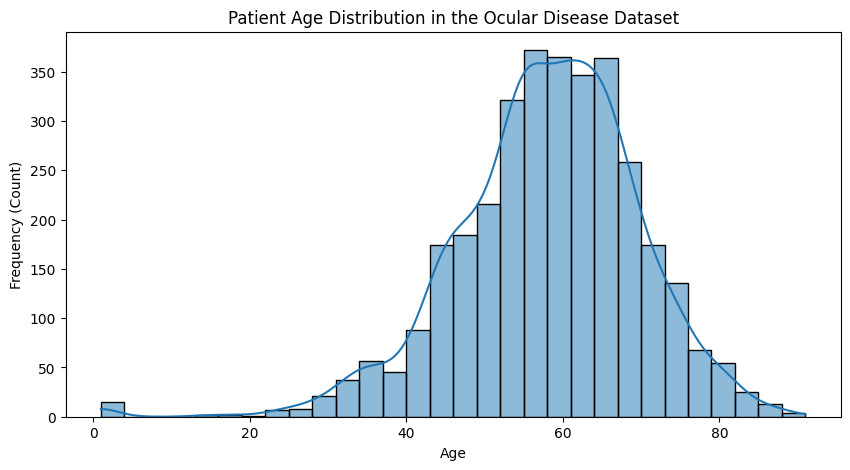

In [39]:
# --- Patient Age ---
print("\n--- Univariate: Patient Age ---")
print(df2['Patient Age'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df2['Patient Age'], kde=True, bins=30)
plt.title('Patient Age Distribution in the Ocular Disease Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency (Count)')
plt.show()


--- Univariate: Patient Sex ---
Patient Sex
Male      0.536033
Female    0.463967
Name: proportion, dtype: float64


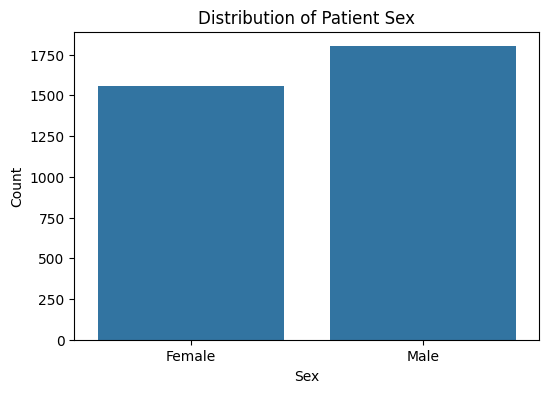

In [40]:
# --- Patient Sex ---
print("\n--- Univariate: Patient Sex ---")
print(df2['Patient Sex'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Sex', data=df2)
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


--- Univariate: Target Label (Disease) Distribution ---
D    1105
N    1080
O     905
C     208
G     206
M     171
A     163
H     103
dtype: int64


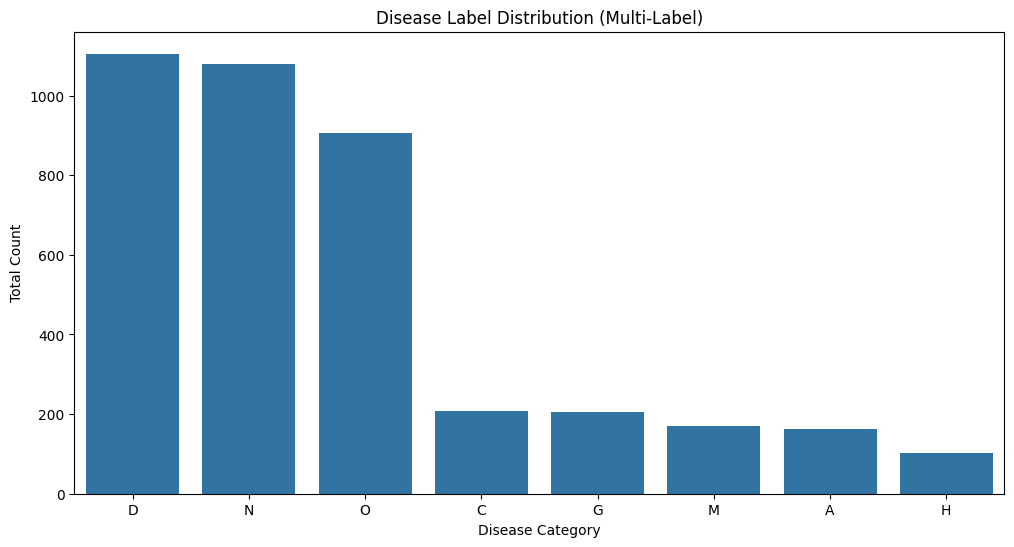

In [41]:
# --- Target Labels (Diseases) ---
print("\n--- Univariate: Target Label (Disease) Distribution ---")
# N=Normal, D=Diabetes, G=Glaucoma, C=Cataract, A=AMD, H=Hypertension, M=Myopia, O=Other
Ohe_cols = df2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']]

disease_counts = Ohe_cols.sum().sort_values(ascending=False)
print(disease_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=disease_counts.index, y=disease_counts.values)
plt.title('Disease Label Distribution (Multi-Label)')
plt.xlabel('Disease Category')
plt.ylabel('Total Count')
plt.show()


--- Multivariate: Disease Co-occurrence Heatmap ---


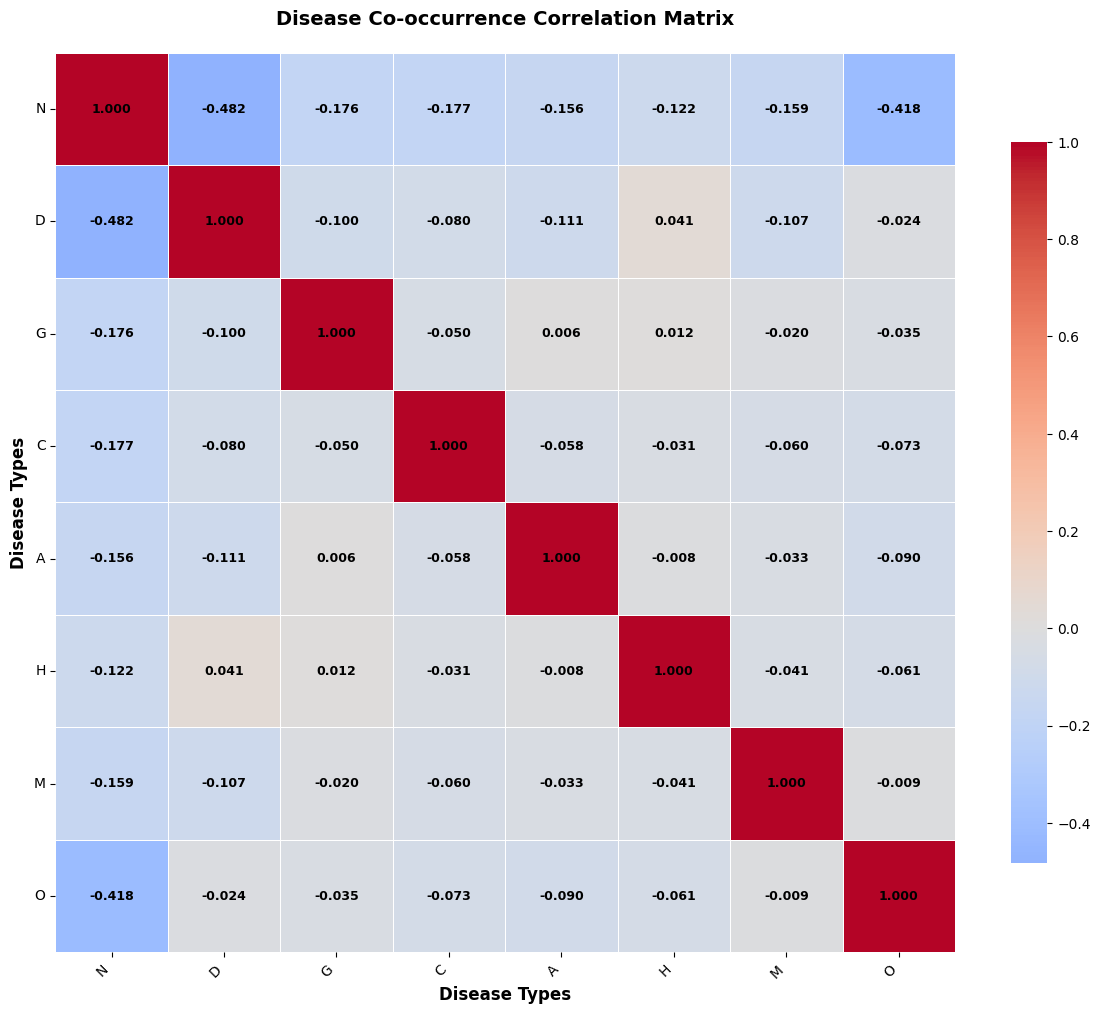

In [42]:
# --- Disease Co-occurrence ---
print("\n--- Multivariate: Disease Co-occurrence Heatmap ---")

correlation_matrix = Ohe_cols.corr()

fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap without annotations first
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=False,  
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    ax=ax
)
# Manually add annotations to every cell
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j + 0.5, i + 0.5, f'{correlation_matrix.iloc[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=9, weight='bold')

plt.title('Disease Co-occurrence Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Disease Types', fontsize=12, fontweight='bold')
plt.ylabel('Disease Types', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We can see from our correlation matrix that Hypertension sometimes occur together with either Diabetes or Glaucoma.

## Visual Inspection
Let's define a function to display images for Visual inspection

In [43]:
import os
import cv2
def display_images(image_filenames:list[str], title="Image DataSet", col_count = 10, w=512, h=512):
    img_count = len(image_filenames)
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=10)
    row_count = (img_count + col_count - 1) // col_count  # Calculate number of rows needed
    for i in range(1, img_count+1):
        plt.subplot(row_count, col_count, i)
        image_path=os.path.join(IMG_DIR, image_filenames[i-1])
        if not os.path.exists(image_path):
            print(f"Image file not found: {image_path}")
            continue
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (w, h))
        img = img / 255.
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_filenames[i-1].split('/')[-1]}", fontsize=8)
        plt.axis(False);
    plt.show()

def display_sample_images(df, title="Sample Images from Ocular Disease Dataset", sample_size=10):
    sample_df = df.sample(sample_size, random_state=42)
    left_fundus = sample_df['Left-Fundus'].tolist()
    right_fundus = sample_df['Right-Fundus'].tolist()
    image_filenames = left_fundus + right_fundus
    display_images(image_filenames, title=title, col_count=sample_size)

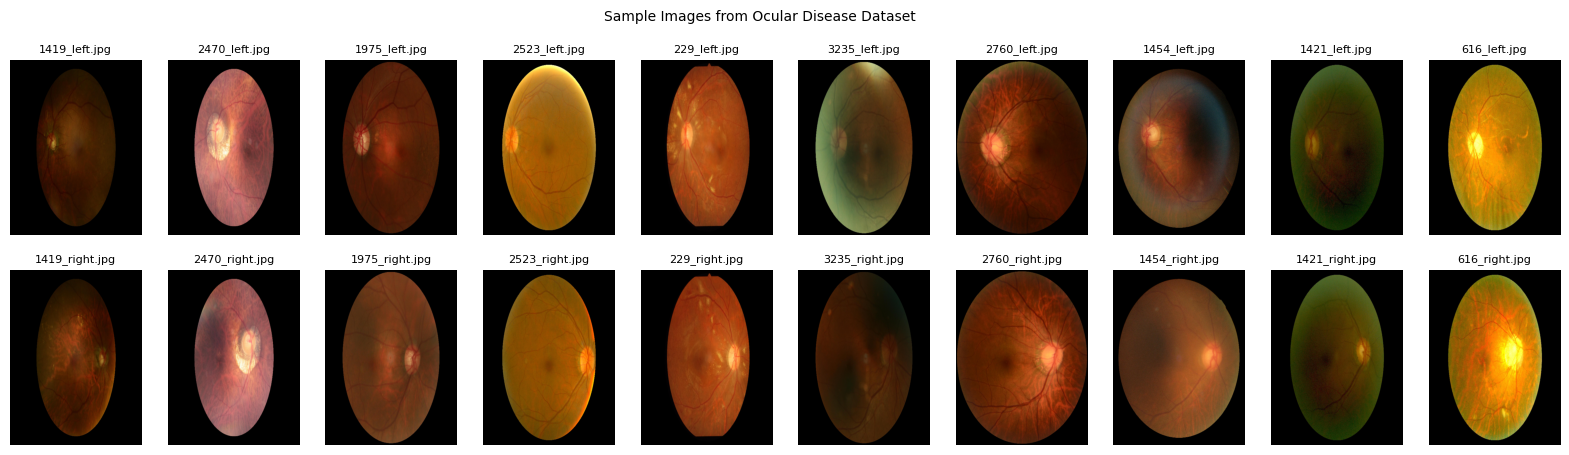

In [44]:
display_sample_images(df2)
#/home/ray/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/preprocessed_images

## Filter Images 

Some images may have been processed and differ greatly from pre-processed images. 
Ref : https://github.com/JordiCorbilla/ocular-disease-intelligent-recognition-deep-learning/blob/2636f77ebb9aab42cc95f45ab680bbbbe5fcc715/list_discarded_images.md?plain=1#L180

From https://odir2019.grand-challenge.org/Download/ special explanation
<blockquote>
      The background of the following images is quite different from the rest ones. They are fundus images uploaded from the hospital. 
	   We are sure that these images are preprocessed. You can decide by yourself whether or not to train these images in the model. 
	   These images include
		2174_right.jpg, 2175_left.jpg,
		2176_left.jpg, 2177_left.jpg,
		2177_right.jpg, 2178_right.jpg,
		2179_left.jpg, 2179_right.jpg,
		2180_left.jpg, 2180_right.jpg,
		2181_left.jpg,
		2181_right.jpg,
		2182_left.jpg,
		2182_right.jpg,
		2957_left.jpg,
		2957_right.jpg
</blockquote>
Let's display them 


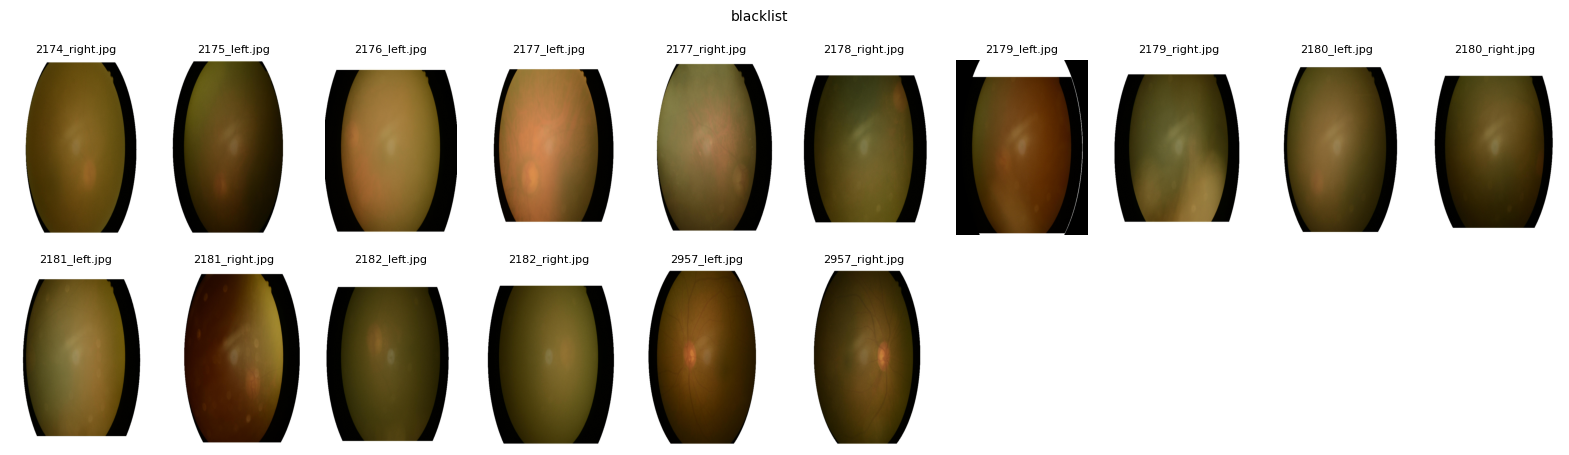

In [45]:
blacklist = ['2174_right.jpg', '2175_left.jpg', '2176_left.jpg', '2177_left.jpg', '2177_right.jpg',
                     '2178_right.jpg', '2179_left.jpg', '2179_right.jpg', '2180_left.jpg', '2180_right.jpg',
                     '2181_left.jpg', '2181_right.jpg', '2182_left.jpg', '2182_right.jpg', '2957_left.jpg',
                     '2957_right.jpg']
display_images(blacklist,title="blacklist")

We can see these images are quite different and we should filter or remove them from our list

In [46]:
# keep only rows where neither left nor right fundus image is in the blacklist
total_rows_in_blacklist = df2[['Left-Fundus', 'Right-Fundus']].isin(blacklist).sum().sum()
print(f"Before removing blacklisted images, the dataset has {total_rows_in_blacklist} observations containing blacklisted images")
condition_to_keep=~df2['Left-Fundus'].isin(blacklist) & ~df2['Right-Fundus'].isin(blacklist)
df2 = df2[condition_to_keep]
total_rows_in_blacklist = df2[['Left-Fundus', 'Right-Fundus']].isin(blacklist).sum().sum()
print(f"After removing blacklisted images, the dataset has {total_rows_in_blacklist} observations containing blacklisted images")


Before removing blacklisted images, the dataset has 16 observations containing blacklisted images
After removing blacklisted images, the dataset has 0 observations containing blacklisted images


We also want to remove low quality 

we are aware of 2 possible noises "lens dust" and "optic disk photographically invisible" which may lead to wrong analysis
- lens dust : could be dust in camera or eyes
- optic disk photographically invisible : poor image where optic disc cannot be identified indicating low quality image

optic disk photographically invisible:
	-left 3
	-right 1
lens dust:
	-right 106
	-left 118


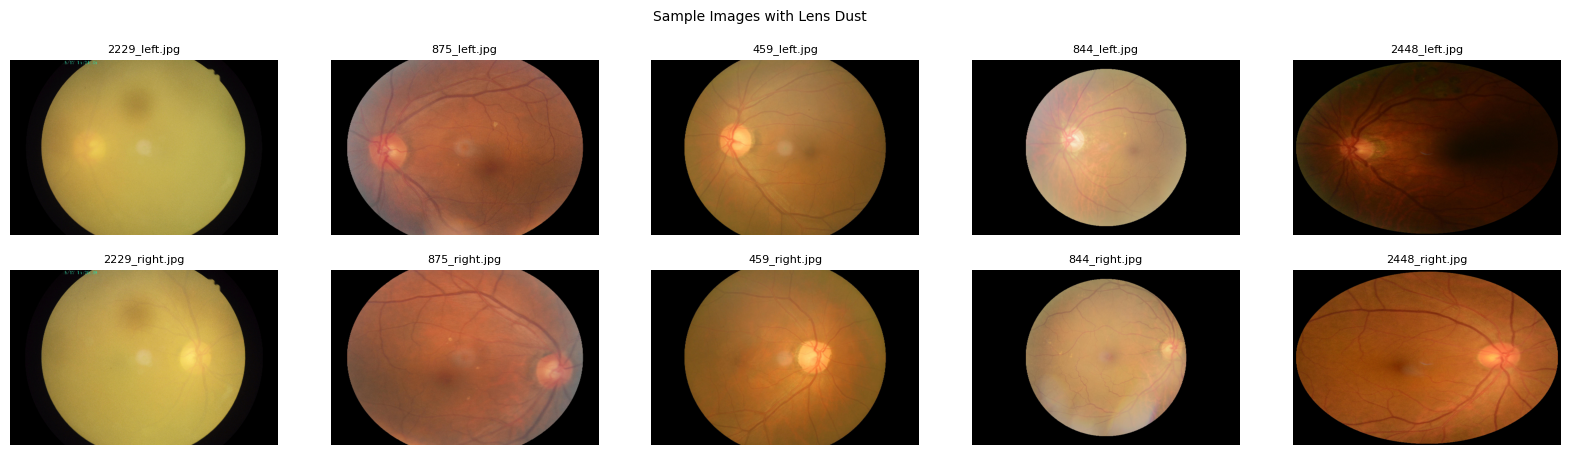

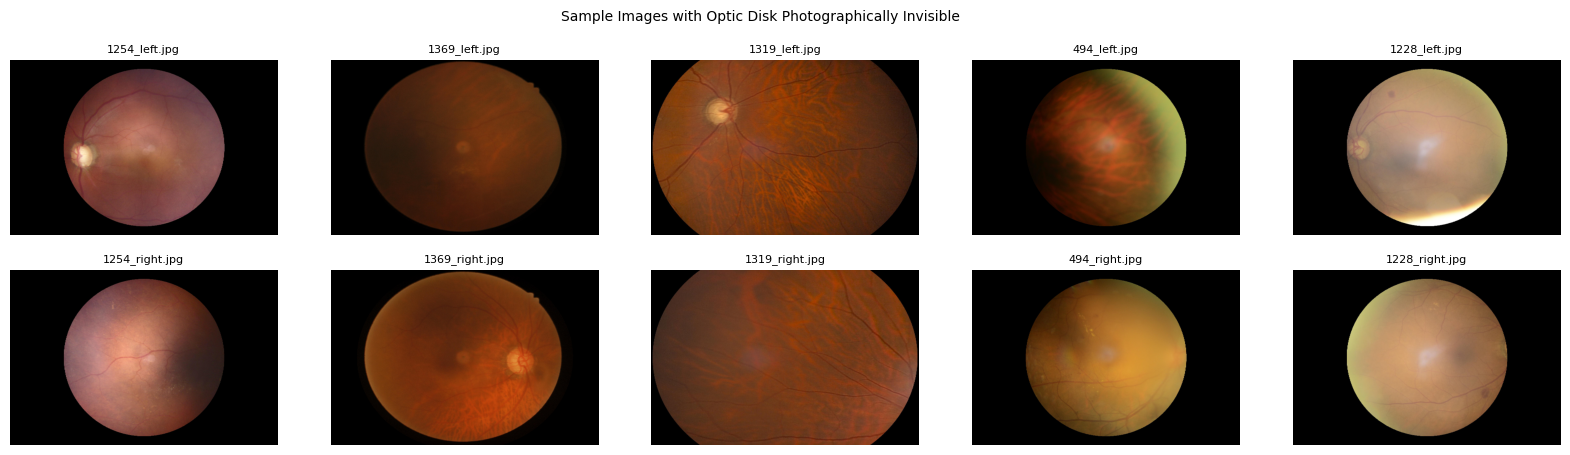

In [47]:
print("optic disk photographically invisible:")
print("\t-left", len(df2[df2['Left-Diagnostic Keywords']=='optic disk photographically invisible']))
print("\t-right", len(df2[df2['Right-Diagnostic Keywords']=='optic disk photographically invisible']))
print("lens dust:")
print("\t-right", len(df2[df2['Right-Diagnostic Keywords'].str.contains("lens dust")]))
print("\t-left", len(df2[df2['Left-Diagnostic Keywords'].str.contains("lens dust")]))
has_lens_dust=df2['Right-Diagnostic Keywords'].str.contains("lens dust") | df2['Left-Diagnostic Keywords'].str.contains("lens dust")
lens_dust_df = df2[has_lens_dust]
has_optic_disk_invisible=df2['Right-Diagnostic Keywords'].str.contains("optic disk photographically invisible") | df2['Left-Diagnostic Keywords'].str.contains("optic disk photographically invisible")
optic_disk_invisible_df = df2[has_optic_disk_invisible]
display_sample_images(lens_dust_df, title="Sample Images with Lens Dust", sample_size=5)
display_sample_images(optic_disk_invisible_df, title="Sample Images with Optic Disk Photographically Invisible", sample_size=5)

Let us remove those noise images too

In [48]:
condition_to_keep=~df2['Right-Diagnostic Keywords'].str.contains("lens dust") & ~df2['Left-Diagnostic Keywords'].str.contains("lens dust")
print("Before removing lens dust images, dataset has", len(df2[df2[['Right-Diagnostic Keywords', 'Left-Diagnostic Keywords']].apply(lambda x: x.str.contains("lens dust").any(), axis=1)]), "observations containing lens dust")
df2 = df2[condition_to_keep]
print("After removing lens dust images, dataset has", len(df2[df2[['Right-Diagnostic Keywords', 'Left-Diagnostic Keywords']].apply(lambda x: x.str.contains("lens dust").any(), axis=1)]), "observations containing lens dust")
condition_to_keep=~df2['Right-Diagnostic Keywords'].str.contains("optic disk photographically invisible") & ~df2['Left-Diagnostic Keywords'].str.contains("optic disk photographically invisible")
print("Before removing optic disk photographically invisible images, dataset has", len(df2[df2[['Right-Diagnostic Keywords', 'Left-Diagnostic Keywords']].apply(lambda x: x.str.contains("optic disk photographically invisible").any(), axis=1)]), "observations containing optic disk photographically invisible")
df2 = df2[condition_to_keep]
print("After removing optic disk photographically invisible images, dataset has", len(df2[df2[['Right-Diagnostic Keywords', 'Left-Diagnostic Keywords']].apply(lambda x: x.str.contains("optic disk photographically invisible").any(), axis=1)]), "observations containing optic disk photographically invisible" )
df2.to_csv("images_keywords_filtered.csv", index=False)

Before removing lens dust images, dataset has 170 observations containing lens dust
After removing lens dust images, dataset has 0 observations containing lens dust
Before removing optic disk photographically invisible images, dataset has 5 observations containing optic disk photographically invisible
After removing optic disk photographically invisible images, dataset has 0 observations containing optic disk photographically invisible


In [49]:
import cv2
df2=pd.read_csv("images_keywords_filtered.csv")
def blur_score(image_path): 
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None: 
        return True,0
    # < 50	Severe Blur	Auto-Delete, 50 - 150	Borderline	Manual Audit, 150	Sharp	Keep    
    # Calculate the Laplacian variance
    # A low score means few sharp edges (blur)
    score = cv2.Laplacian(image, cv2.CV_64F).var()
    
    return score

def get_image_dimensions(image_path):
    """
    Gets the width and height of an image without loading the full raster data.

    Args:
        image_path (str): The path to the image file.

    Returns:
        tuple: A tuple containing (width, height) in pixels.
    """
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except IOError:
        print(f"Cannot open image file: {image_path}")
        return None, None
csv_name = "images_analysis.csv"
if os.path.exists(csv_name):
    print("Loading existing csv...")
    df2 = pd.read_csv(csv_name )
else:    
    for index, row in df2.iterrows():
        for columns in ['Left-Fundus', 'Right-Fundus']:
            image_path = os.path.join(IMG_DIR, row[columns])
            score = blur_score(image_path)
            width, height = get_image_dimensions(image_path)
            df2.at[index, f'{columns}-blur-score'] = score
            df2.at[index, f'{columns}-width'] = width
            df2.at[index, f'{columns}-height'] = height
    df2.to_csv(csv_name, index=False)
    print("Image quality analysis completed. Results saved to csv")
print("Image dimensions (Left-Fundus):")
print(df2[['Left-Fundus-width', 'Left-Fundus-height']].describe())
print("Image dimensions (Right-Fundus):")
print(df2[['Right-Fundus-width', 'Right-Fundus-height']].describe())    

Loading existing csv...
Image dimensions (Left-Fundus):
       Left-Fundus-width  Left-Fundus-height
count        3173.000000         3173.000000
mean         2454.467066         1800.727702
std           610.250492          418.531351
min           250.000000          188.000000
25%          2048.000000         1632.000000
50%          2592.000000         1728.000000
75%          2592.000000         1944.000000
max          5184.000000         3456.000000
Image dimensions (Right-Fundus):
       Right-Fundus-width  Right-Fundus-height
count         3173.000000          3173.000000
mean          2455.497951          1801.855342
std            608.682550           417.476229
min            250.000000           188.000000
25%           2048.000000          1632.000000
50%           2592.000000          1728.000000
75%           2592.000000          1944.000000
max           5184.000000          3456.000000


In [50]:
df2.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,H,M,O,multiple,Left-Fundus-blur-score,Left-Fundus-width,Left-Fundus-height,Right-Fundus-blur-score,Right-Fundus-width,Right-Fundus-height
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,1,58.989058,2304.0,1728.0,17.069750,2304.0,1728.0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,1,41.329046,3456.0,2304.0,35.325069,3456.0,2304.0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,1,2,54.739564,2048.0,1536.0,25.763990,2048.0,1536.0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,1,2,192.179904,1920.0,894.0,235.463112,1920.0,894.0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,50.858439,2304.0,1728.0,74.798563,2304.0,1728.0


Number of blurry images: 731


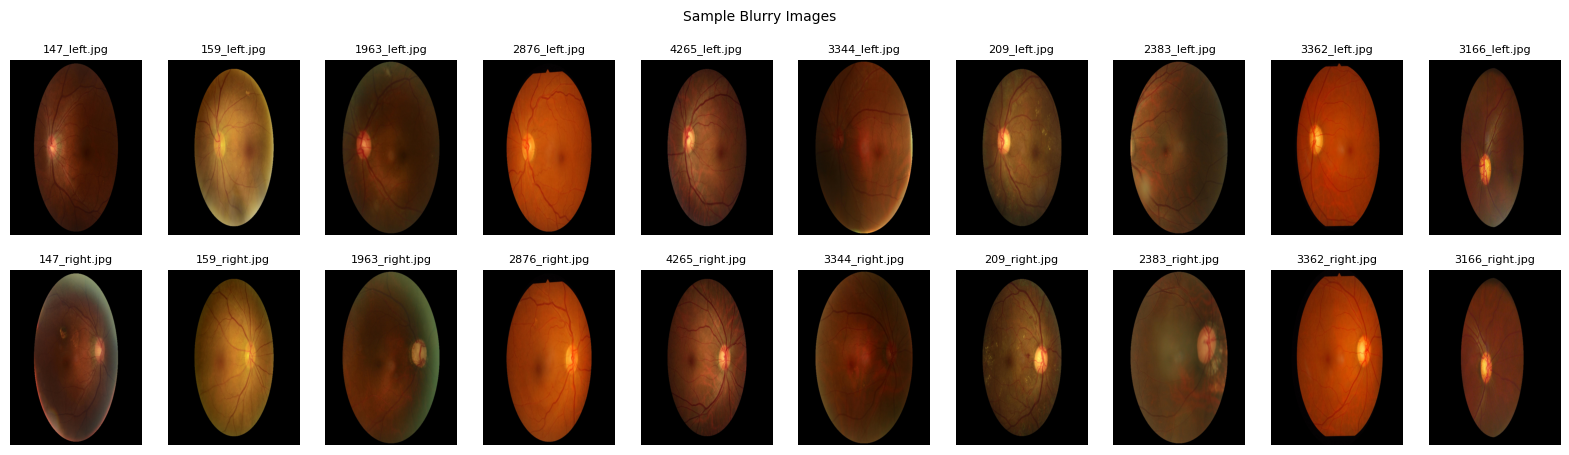

Number of non-blurry images: 2442


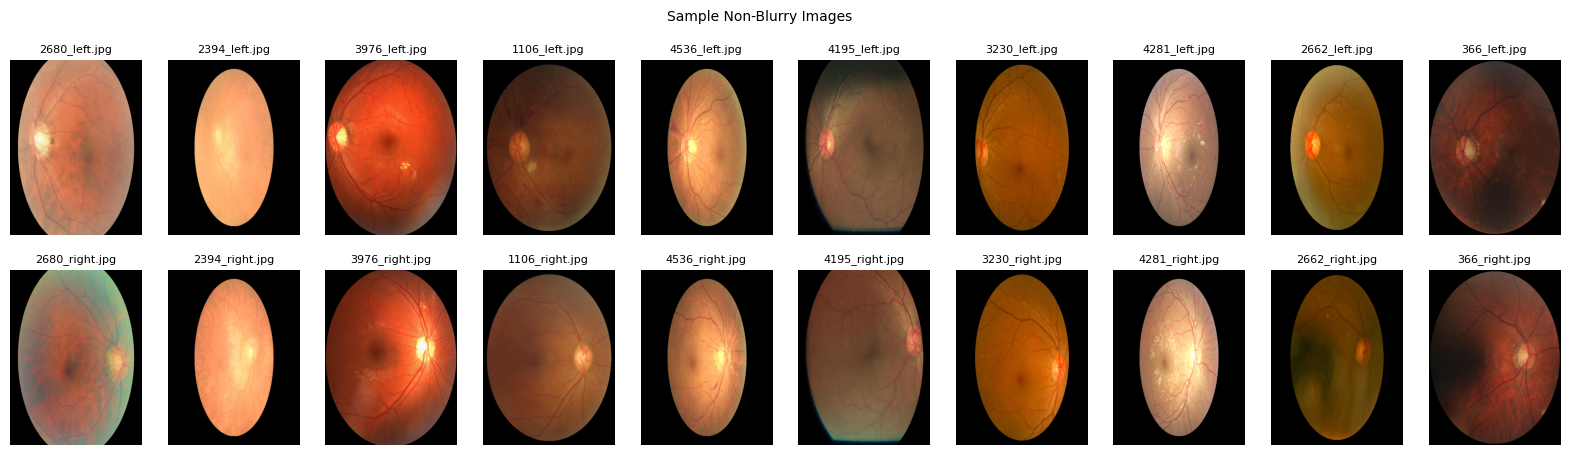

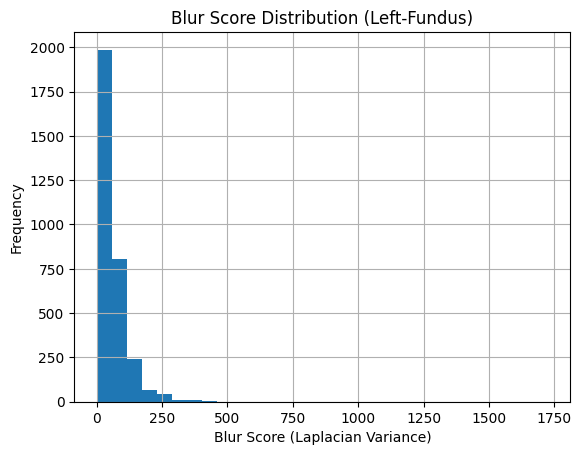

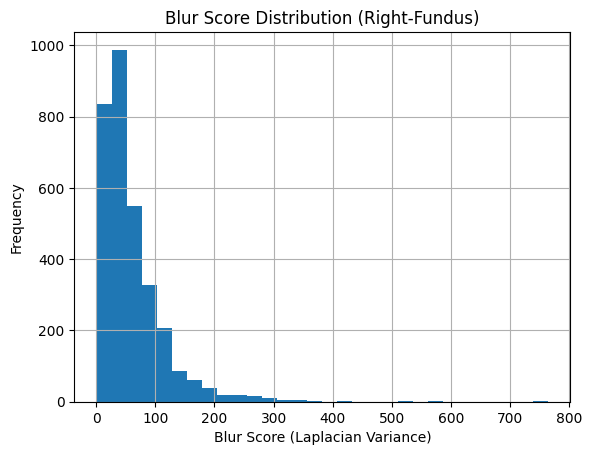

In [51]:
csv_name = "images_analysis.csv"
df2 = pd.read_csv(csv_name)
threshold = 20
condition_to_detect=(df2['Right-Fundus-blur-score']<threshold) | (df2['Left-Fundus-blur-score']<threshold)
blurry_images_df = df2[condition_to_detect]
print(f"Number of blurry images: {len(blurry_images_df)}")
display_sample_images(blurry_images_df, title="Sample Blurry Images", sample_size=10)
condition_to_keep=~(df2['Right-Fundus-blur-score']<threshold) & ~(df2['Left-Fundus-blur-score']<threshold)
non_blurry_images_df = df2[condition_to_keep]
print(f"Number of non-blurry images: {len(non_blurry_images_df)}")
display_sample_images(non_blurry_images_df, title="Sample Non-Blurry Images", sample_size=10)
df2['Left-Fundus-blur-score'].hist(bins=30)
plt.title('Blur Score Distribution (Left-Fundus)')
plt.xlabel('Blur Score (Laplacian Variance)')
plt.ylabel('Frequency')
plt.show()
df2['Right-Fundus-blur-score'].hist(bins=30)
plt.title('Blur Score Distribution (Right-Fundus)')
plt.xlabel('Blur Score (Laplacian Variance)')
plt.ylabel('Frequency')
plt.show()

In [52]:
csv_name = "images_analysis.csv"
df2 = pd.read_csv(csv_name)
for threshold in [5, 10, 20, 30, 50]:
    condition_to_keep=~(df2['Right-Fundus-blur-score']<threshold) & ~(df2['Left-Fundus-blur-score']<threshold)
    condition_to_detect=(df2['Right-Fundus-blur-score']<threshold) | (df2['Left-Fundus-blur-score']<threshold)
    count_blurry_images = df2[condition_to_detect].shape[0]
    count_non_blurry_images = df2[condition_to_keep].shape[0]
    print(f"Threshold {threshold}: {count_blurry_images} patients with blurry images, {count_non_blurry_images} non-blurry images")

Threshold 5: 72 patients with blurry images, 3101 non-blurry images
Threshold 10: 272 patients with blurry images, 2901 non-blurry images
Threshold 20: 731 patients with blurry images, 2442 non-blurry images
Threshold 30: 1231 patients with blurry images, 1942 non-blurry images
Threshold 50: 2064 patients with blurry images, 1109 non-blurry images


It seemed we have a lot of blurry images, removing most of them is not a good idea.

Let us just remove as little as we could i.e. 72 patients with threshold 5

In [53]:
threshold = 5
condition_to_keep=~(df2['Right-Fundus-blur-score']<threshold) & ~(df2['Left-Fundus-blur-score']<threshold)
condition_to_detect=(df2['Right-Fundus-blur-score']<threshold) | (df2['Left-Fundus-blur-score']<threshold)
count_blurry_images = df2[condition_to_detect].shape[0]
count_non_blurry_images = df2[condition_to_keep].shape[0]
print(f"Threshold {threshold}: {count_blurry_images} patients with blurry images, {count_non_blurry_images} non-blurry images")
df2 = df2[condition_to_keep]
df2.to_csv("images_clean.csv", index=False)

Threshold 5: 72 patients with blurry images, 3101 non-blurry images


# Split train vs validation

In [54]:
df2 = pd.read_csv("images_clean.csv")
y = df2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']] # we will use the individual disease labels for modeling
X = df2.drop(['multiple', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 
              'ID', 'Patient Age', 'Patient Sex', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords',
              'Left-Fundus-width', 'Right-Fundus-width',
              'Left-Fundus-height', 'Right-Fundus-height',
              'Left-Fundus-blur-score','Right-Fundus-blur-score'], axis=1) 
# we do not need the ID, Patient Age or Sex for modeling, and 'multiple' is derived from the target labels
print("Feature columns:", X.columns.tolist())
print("Target columns:", y.columns.tolist())
print("Rows count X:", len(X))
print("Rows count y:", len(y))
X.head()


Feature columns: ['Left-Fundus', 'Right-Fundus']
Target columns: ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
Rows count X: 3101
Rows count y: 3101


,Left-Fundus,Right-Fundus
0,0_left.jpg,0_right.jpg
1,1_left.jpg,1_right.jpg
2,2_left.jpg,2_right.jpg
3,4_left.jpg,4_right.jpg
4,5_left.jpg,5_right.jpg


In [55]:
y.head()

,N,D,G,C,A,H,M,O
0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0


In [56]:
import pandas as pd
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
def iterative_train_test_split_dataframe(X, y, test_size):
    noob_train_test_split = iterative_train_test_split
    X_train, y_train, X_test, y_test = noob_train_test_split(X.reset_index().to_numpy(), y.to_numpy(), test_size=test_size)

    df_X_train = pd.DataFrame(X_train[:, 1:], columns=X.columns, index=X_train[:, 0])
    df_y_train = pd.DataFrame(y_train, columns=y.columns, index=df_X_train.index)
    df_X_test = pd.DataFrame(X_test[:, 1:], columns=X.columns, index=X_test[:, 0])
    df_y_test = pd.DataFrame(y_test, columns=y.columns, index=df_X_test.index)
    return df_X_train, df_y_train, df_X_test, df_y_test

In [57]:
if os.path.exists("train.csv") and os.path.exists("val.csv") and os.path.exists("test.csv"):
    print("Train, validation, and test CSV files already exist. Skipping data splitting.")
    train_df = pd.read_csv("train.csv")
    val_df = pd.read_csv("val.csv")
    test_df = pd.read_csv("test.csv")
else:
    X_train, y_train, X_val, y_val = iterative_train_test_split_dataframe(X, y, test_size=0.2)
    train_df = pd.concat([X_train, y_train], axis=1)
    X_val, y_val, X_test, y_test = iterative_train_test_split_dataframe(X_val, y_val, test_size=0.5)
    val_df = pd.concat([X_val, y_val], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    train_df.to_csv("train.csv", index=False)
    val_df.to_csv("val.csv", index=False)
    test_df.to_csv("test.csv", index=False)
print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Training samples: 2482
Validation samples: 306
Test samples: 313


We need to check whether the stratification work : Training, Validation and Test have the same distribution of diseases.

Let's plot normalized distribution and see whether the above is true

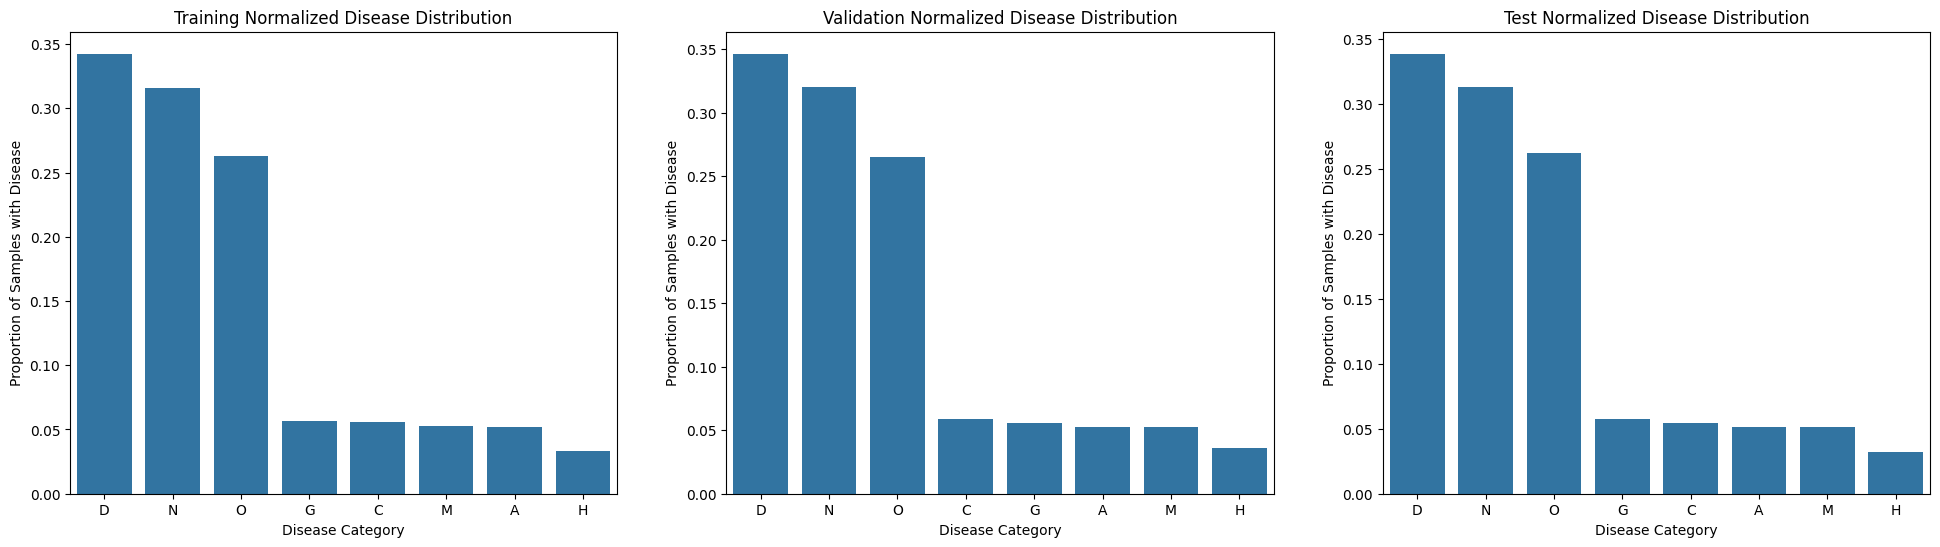

In [58]:
# N=Normal, D=Diabetes, G=Glaucoma, C=Cataract, A=AMD, H=Hypertension, M=Myopia, O=Other
def plot_disease_distribution(df, title, subplot_index):
    Ohe_cols = df[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']]    
    disease_counts = Ohe_cols.sum().sort_values(ascending=False)
    # print(disease_counts)
    disease_counts_normalized = disease_counts / len(df)
    # print(disease_counts_normalized)
    plt.subplot(1, 3, subplot_index)
    sns.barplot(x=disease_counts_normalized.index, y=disease_counts_normalized.values)
    plt.title(f'{title} Normalized Disease Distribution')
    plt.xlabel('Disease Category')
    plt.ylabel('Proportion of Samples with Disease')
plt.figure(figsize=(24, 6))
plot_disease_distribution(train_df, "Training", 1)
plot_disease_distribution(val_df, "Validation", 2)
plot_disease_distribution(test_df, "Test", 3)
plt.show()
